# Réalisé par:

- Amel Lattari

- Amina Tadjin

- *Nour* El Houda Mounia Ikhelef

# Bibliotèques à installer :      



In [1]:
pip install keras-tuner

# 1. Analyse Exploratoire des Données (EDA) :

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le dataset pour examiner les premières lignes
file_path = 'sales_train.csv'
data = pd.read_csv(file_path)

# Afficher les premières lignes pour voir la structure des données
data.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Le dataset contient les colonnes suivantes :

**date** : Date de la transaction (format : jour.mois.année).

**date_block_num** : Numéro de mois du bloc (numéro unique pour chaque mois).

**shop_id** : Identifiant du magasin.

**item_id** : Identifiant de l'article.

**item_price** : Prix de l'article.

**item_cnt_day** : Quantité vendue de l'article ce jour-là (positive ou négative).


**Nettoyage des données**: Vérifier et traiter les valeurs manquantes, les valeurs aberrantes (notamment les prix négatifs ou improbables, et les quantités négatives dans item_cnt_day).

**Transformation de la date**: Convertir la colonne date en format de date standard pour simplifier les analyses par période.

**Statistiques descriptives**: Afficher les statistiques de base, comme le prix moyen, la quantité totale vendue, et le nombre total de transactions par mois, magasin ou article.

In [3]:
# Nettoyage des données : vérifier les valeurs manquantes et aberrantes
# Vérifier les valeurs manquantes
missing_values = data.isnull().sum()

# Vérifier les valeurs aberrantes dans 'item_price' et 'item_cnt_day'
# Par exemple, item_price ne devrait pas être négatif ou extrêmement élevé
# et item_cnt_day ne devrait pas être négatif dans la majorité des cas
outliers_price = data[data['item_price'] < 0]
outliers_cnt = data[data['item_cnt_day'] < 0]

# Afficher les valeurs manquantes et les valeurs aberrantes trouvées
missing_values, outliers_price, outliers_cnt


(date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64,
               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 484683  15.05.2013               4       32     2973        -1.0           1.0,
                date  date_block_num  shop_id  item_id  item_price  \
 2        05.01.2013               0       25     2552       899.0   
 148      23.01.2013               0       25     2321       999.0   
 175      07.01.2013               0       25     2199      1449.0   
 807      02.01.2013               0       25     2330       599.0   
 1041     13.01.2013               0       25     5034      1989.0   
 ...             ...             ...      ...      ...         ...   
 2934243  26.10.2015              33       25     3917       449.0   
 2934462  18.10.2015              33       25     4896      6398.0   
 2935263  05.10.2015              33       25    10039       249.0  

In [4]:
# Suppression de la ligne avec un prix négatif
data = data[data['item_price'] >= 0]

# Mettre les valeurs négatives de 'item_cnt_day' à zéro
# en supposant que ces valeurs représentent des erreurs plutôt que des retours
data['item_cnt_day'] = data['item_cnt_day'].apply(lambda x: max(x, 0))

# Conversion de la colonne 'date' au format datetime pour faciliter les analyses
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Vérification des changements effectués
data.head()
data.describe()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935848,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06,2.935848e+06
mean,2014-04-03 05:44:44.483393536,1.456992e+01,3.300173e+01,1.019723e+04,8.908535e+02,1.245210e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,0.000000e+00
25%,2013-08-01 00:00:00,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03
std,NaN,9.422987e+00,1.622698e+01,6.324297e+03,1.729800e+03,2.617046e+00


In [5]:
# Calcul des statistiques descriptives de base

# Moyenne et écart type des prix des articles
price_stats = data['item_price'].describe()

# Total des ventes (quantités) par mois
monthly_sales = data.groupby(data['date'].dt.to_period("M"))['item_cnt_day'].sum()

# Total des ventes par magasin
sales_by_shop = data.groupby('shop_id')['item_cnt_day'].sum()

# Total des ventes par article
sales_by_item = data.groupby('item_id')['item_cnt_day'].sum()

price_stats, monthly_sales.head(), sales_by_shop.head(), sales_by_item.head()


(count    2.935848e+06
 mean     8.908535e+02
 std      1.729800e+03
 min      7.000000e-02
 25%      2.490000e+02
 50%      3.990000e+02
 75%      9.990000e+02
 max      3.079800e+05
 Name: item_price, dtype: float64,
 date
 2013-01    131850.0
 2013-02    128382.0
 2013-03    147438.0
 2013-04    107439.0
 2013-05    107147.0
 Freq: M, Name: item_cnt_day, dtype: float64,
 shop_id
 0    11705.0
 1     6311.0
 2    30706.0
 3    28475.0
 4    44069.0
 Name: item_cnt_day, dtype: float64,
 item_id
 0    1.0
 1    6.0
 2    2.0
 3    2.0
 4    1.0
 Name: item_cnt_day, dtype: float64)

In [6]:
# 1. Calculer les statistiques de prix des articles :

# Moyenne, médiane, et autres statistiques descriptives de la colonne 'item_price'
price_stats = data['item_price'].describe()
print("Statistiques des prix des articles :\n", price_stats)
# 2. Calculer les ventes mensuelles

# Total des ventes (quantités) par mois
monthly_sales = data.groupby(data['date'].dt.to_period("M"))['item_cnt_day'].sum()
print("Ventes mensuelles :\n", monthly_sales.head())
# 3. Calculer les ventes par magasin et par article

# Total des ventes par magasin
sales_by_shop = data.groupby('shop_id')['item_cnt_day'].sum()
print("Ventes totales par magasin :\n", sales_by_shop.head())

# Total des ventes par article
sales_by_item = data.groupby('item_id')['item_cnt_day'].sum()
print("Ventes totales par article :\n", sales_by_item.head())

Statistiques des prix des articles :
 count    2.935848e+06
mean     8.908535e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64
Ventes mensuelles :
 date
2013-01    131850.0
2013-02    128382.0
2013-03    147438.0
2013-04    107439.0
2013-05    107147.0
Freq: M, Name: item_cnt_day, dtype: float64
Ventes totales par magasin :
 shop_id
0    11705.0
1     6311.0
2    30706.0
3    28475.0
4    44069.0
Name: item_cnt_day, dtype: float64
Ventes totales par article :
 item_id
0    1.0
1    6.0
2    2.0
3    2.0
4    1.0
Name: item_cnt_day, dtype: float64


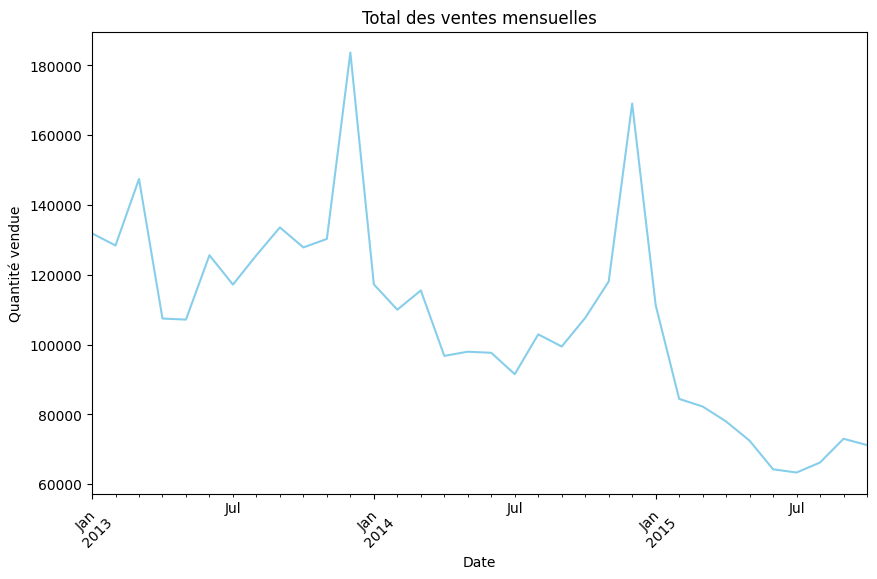

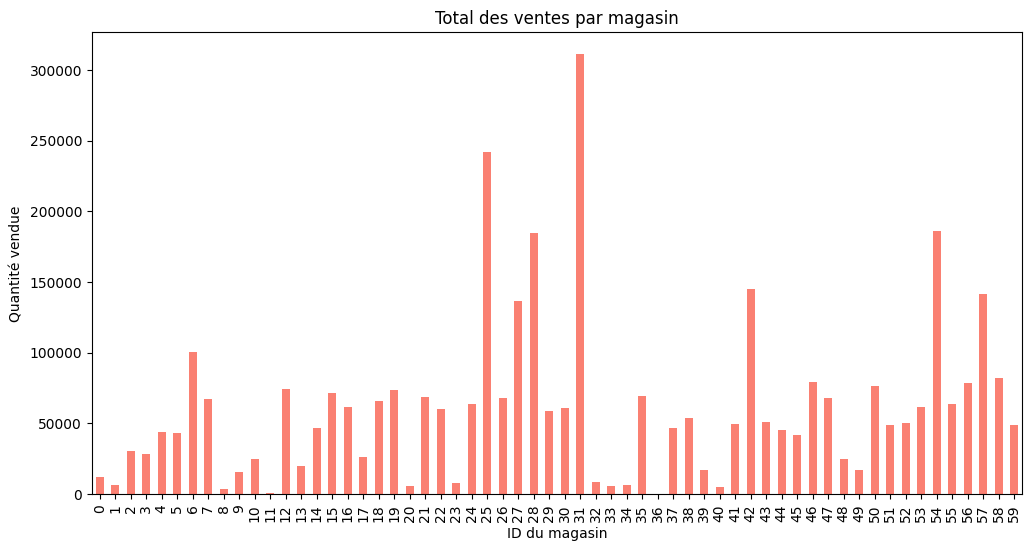

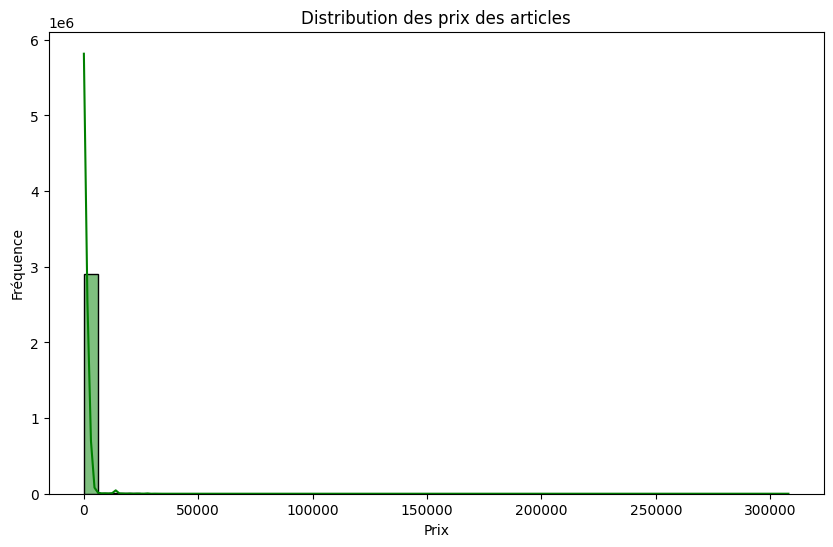

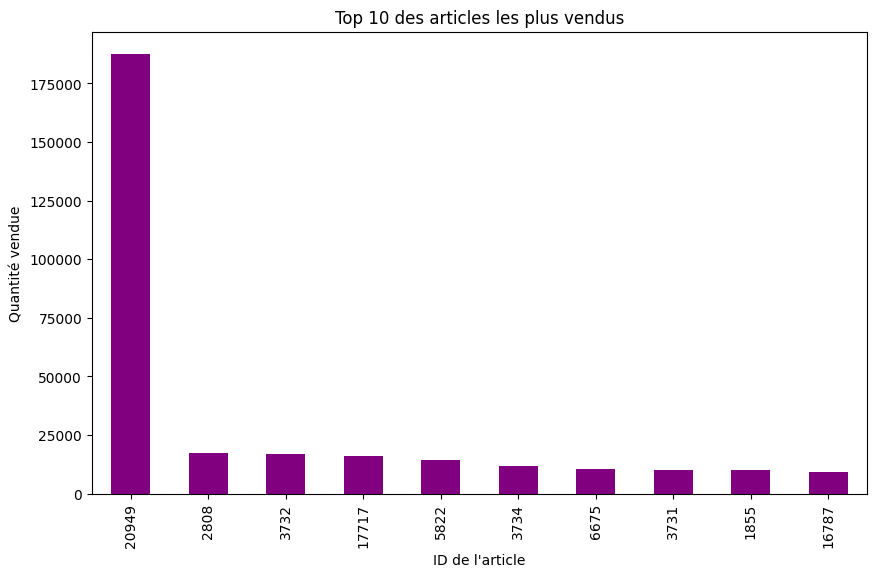

In [7]:
#1. Évolution des ventes mensuelles
#Un graphique de type ligne pour visualiser le total des ventes mensuelles.

# Calcul des ventes mensuelles
monthly_sales = data.groupby(data['date'].dt.to_period("M"))['item_cnt_day'].sum()

# Création du graphique
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', color='skyblue')
plt.title('Total des ventes mensuelles')
plt.xlabel('Date')
plt.ylabel('Quantité vendue')
plt.xticks(rotation=45)
plt.show()
#2. Répartition des ventes par magasin
#Un histogramme ou graphique à barres pour voir quels magasins ont vendu le plus.


# Calcul des ventes totales par magasin
sales_by_shop = data.groupby('shop_id')['item_cnt_day'].sum()

# Création du graphique
plt.figure(figsize=(12, 6))
sales_by_shop.plot(kind='bar', color='salmon')
plt.title('Total des ventes par magasin')
plt.xlabel('ID du magasin')
plt.ylabel('Quantité vendue')
plt.show()
#3. Distribution des prix des articles
#Un histogramme pour voir la répartition des prix des articles.


# Création de l'histogramme des prix des articles
plt.figure(figsize=(10, 6))
sns.histplot(data['item_price'], bins=50, kde=True, color='green')
plt.title('Distribution des prix des articles')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()
#4. Top 10 des articles les plus vendus
#Un graphique à barres pour afficher les 10 articles les plus vendus.

# Calcul des ventes totales par article
sales_by_item = data.groupby('item_id')['item_cnt_day'].sum()
top_items = sales_by_item.nlargest(10)

# Création du graphique
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='purple')
plt.title('Top 10 des articles les plus vendus')
plt.xlabel('ID de l\'article')
plt.ylabel('Quantité vendue')
plt.show()

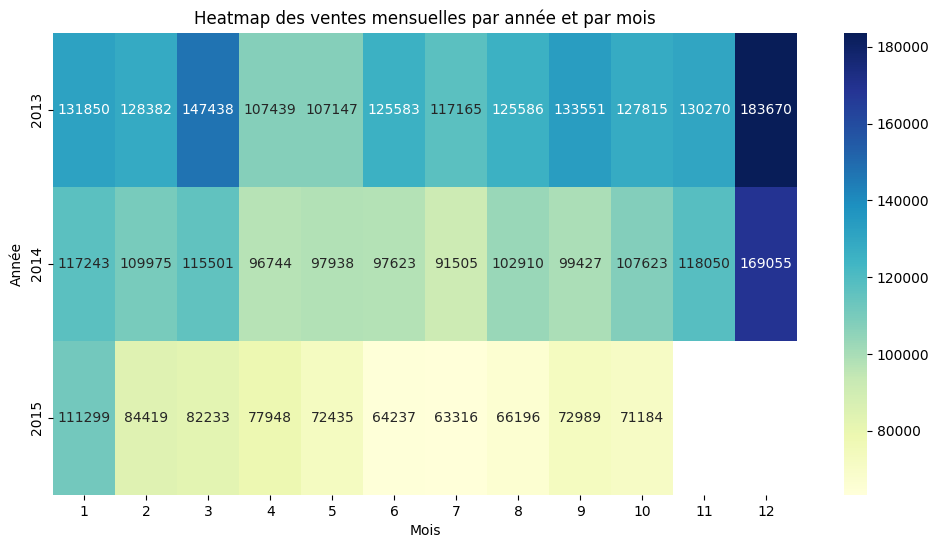

In [8]:
# Extraire l'année et le mois
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Calculer les ventes mensuelles par année et par mois
monthly_sales_pivot = data.pivot_table(index='year', columns='month', values='item_cnt_day', aggfunc='sum')

# Créer la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_sales_pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Heatmap des ventes mensuelles par année et par mois')
plt.xlabel('Mois')
plt.ylabel('Année')
plt.show()


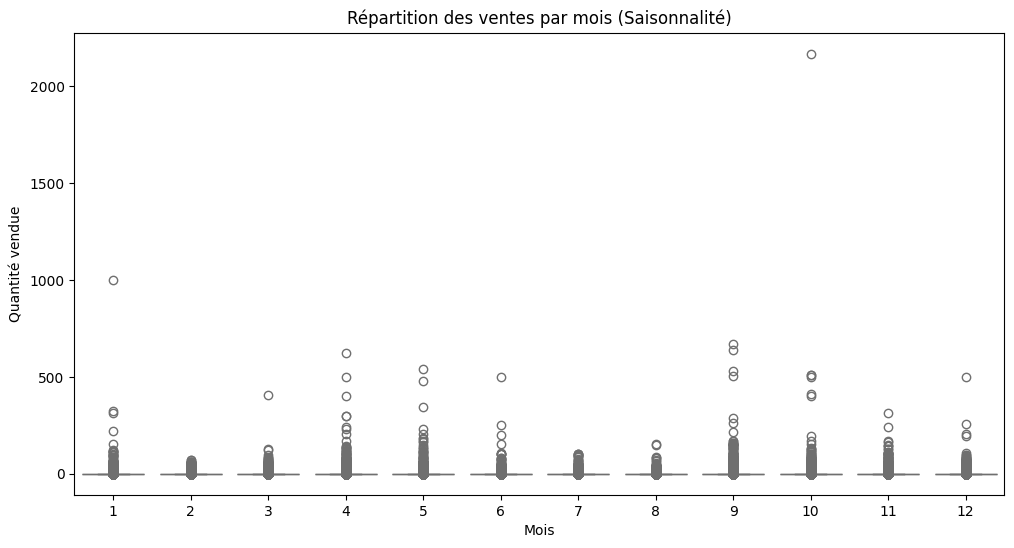

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['date'].dt.month, y=data['item_cnt_day'], color='skyblue')
plt.title('Répartition des ventes par mois (Saisonnalité)')
plt.xlabel('Mois')
plt.ylabel('Quantité vendue')
plt.show()


**Commentaires :**

Entre janvier 2013 et janvier 2015, on observe des variations importantes dans les ventes.
Une augmentation notable se produit à deux moments :
- Fin 2013 : un pic des ventes atteint environ 180 000 unités.
- Fin 2014 : un autre pic similaire.
- Après le début de l'année 2015, les ventes chutent drastiquement pour atteindre un niveau bas constant.
Saisonnalité :

Les ventes semblent avoir une composante saisonnière, avec des hausses significatives suivies de baisses dans des cycles réguliers.
Périodes de faibles ventes :

Une forte baisse est visible après les pics, particulièrement au cours de 2014 et début 2015, où les ventes descendent sous les 60 000 unités.
Interprétation possible :

- Les pics à la fin des années pourraient indiquer une hausse saisonnière, comme des promotions ou des événements (par exemple, Noël ou fin d'année).
La chute après janvier 2015 pourrait être due à des facteurs économiques, une perte d'intérêt des consommateurs, ou un changement dans les produits/services.

# 2. Préparation pour l'Analyse de Série Temporelle :

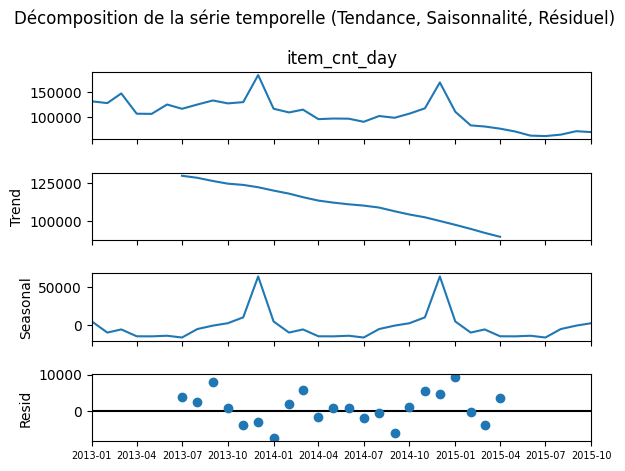

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

monthly_sales = data.groupby(data['date'].dt.to_period("M"))['item_cnt_day'].sum().to_timestamp()
monthly_sales_ts = monthly_sales.astype(float)

# Décomposition de la série temporelle
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Affichage des composantes de la série
fig = decomposition.plot()
fig.suptitle('Décomposition de la série temporelle (Tendance, Saisonnalité, Résiduel)', fontsize=12)

for ax in fig.axes:
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=10)


fig.subplots_adjust(top=0.85, hspace=0.5)

plt.show()


**Interprétation :**

Le graphique présenté est le résultat de la décomposition additive de la série temporelle des ventes mensuelles . Cette décomposition permet de séparer la série en trois composantes principales :



* **Tendance (Trend) :** montre la direction générale de l'évolution des ventes au fil du temps. Dans notre cas la tendance montre une baisse générale des ventes de janvier 2013 à octobre 2015. Cette baisse continue suggère une diminution stable des ventes au fil du temps, ce qui peut être lié à un certain nombre de facteurs externes comme une diminution de la demande ou des changements dans les préférences des consommateurs. Le déclin progressif de cette ligne montre un affaiblissement des ventes à long terme, signalant peut-être une saturation du marché ou des problèmes économiques.
    
    
* **Saisonnalité (Seasonal) :** capture les variations régulières et prévisibles des ventes dues à des facteurs saisonniers.
La saisonnalité ici révèle une variation très marquée qui se répète chaque année. Les pics de ventes se produisent principalement en décembre, suivis d'une forte baisse en janvier. Ce comportement est cohérent avec les attentes des consommateurs qui augmentent leurs achats pour les fêtes de Noël ou du Nouvel An. L'oscillation régulière des ventes pendant l'année (un pic vers décembre et une chute en janvier) confirme que la série est fortement influencée par un cycle annuel.

  
    
    
* **Résidu (Residual) :** représente les fluctuations qui ne sont pas expliquées par la tendance ou la saisonnalité. Ces valeurs sont généralement considérées comme aléatoires ou dues à des événements imprévus.
Dans le graphique des résidus, on observe une certaine dispersion autour de la ligne horizontale (qui représente la moyenne nulle). Cela indique que les fluctuations non expliquées sont relativement aléatoires et n'indiquent pas de tendance spécifique ou de structure sous-jacente évidente.
Cependant, on peut noter quelques points éloignés de la ligne zéro, ce qui peut suggérer des événements inhabituels ou des anomalies, comme des variations exceptionnelles des ventes dues à des facteurs extérieurs.
    

In [11]:
from statsmodels.tsa.stattools import adfuller

# Test de stationnarité (Augmented Dickey-Fuller)
result = adfuller(monthly_sales)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Résultat du test
if result[1] <= 0.05:
    print("La série est stationnaire (p-value <= 0.05).")
else:
    print("La série n'est pas stationnaire (p-value > 0.05).")


ADF Statistic: -2.3923871002170976
p-value: 0.14389663224976484
La série n'est pas stationnaire (p-value > 0.05).


**Interprétation :**

Ces résultats indiquent que la série originale n'est pas stationnaire. Pour garantir la stationnarité, qui est essentielle à l'application de modèles comme ARIMA, nous allons explorer trois approches de transformation. La première consiste à appliquer une différenciation simple pour éliminer la tendance. La deuxième méthode utilise une transformation Box-Cox pour stabiliser la variance, suivie d'une différenciation pour supprimer la tendance. Enfin, la troisième approche repose sur une transformation logarithmique pour réduire les variations, suivie également d'une différenciation. Après avoir testé ces trois méthodes, nous sélectionnerons celle qui stabilise le mieux la série tout en restant adaptée au contexte des données et simple à interpréter.

In [12]:
# Différenciation
monthly_sales_diff = monthly_sales.diff().dropna()

# Test de stationnarité
result_diff = adfuller(monthly_sales_diff)
print("ADF Statistic (différenciée):", result_diff[0])
print("p-value (différenciée):", result_diff[1])

# Résultat du test
if result_diff[1] <= 0.05:
    print("La série est stationnaire (p-value <= 0.05).")
else:
    print("La série n'est pas stationnaire (p-value > 0.05).")


ADF Statistic (différenciée): -13.651699301229545
p-value (différenciée): 1.581349528447448e-25
La série est stationnaire (p-value <= 0.05).


In [13]:
# Transformation Box-Cox
from scipy.stats import boxcox
import numpy as np

if np.any(monthly_sales <= 0):
    monthly_sales_boxcox, lambda_boxcox = boxcox(monthly_sales + abs(monthly_sales.min()) + 1)
else:
    monthly_sales_boxcox, lambda_boxcox = boxcox(monthly_sales)

# Différenciation
monthly_sales_boxcox_diff = np.diff(monthly_sales_boxcox, n=1)

# Test de stationnarité
from statsmodels.tsa.stattools import adfuller
adf_result_boxcox_diff = adfuller(monthly_sales_boxcox_diff)
print("ADF Stat:", adf_result_boxcox_diff[0])
print("p-value:", adf_result_boxcox_diff[1])

# Résultat du test
if adf_result_boxcox_diff[1] <= 0.05:
    print("La série est stationnaire (p-value <= 0.05).")
else:
    print("La série n'est pas stationnaire (p-value > 0.05).")

ADF Stat: -8.172465516675203
p-value: 8.549618766842207e-13
La série est stationnaire (p-value <= 0.05).


In [14]:
# Transformation logarithmique
monthly_sales_log = np.log(monthly_sales + 1)

# Différenciation
monthly_sales_log_diff = monthly_sales_log.diff().dropna()

# Test de stationnarité
from statsmodels.tsa.stattools import adfuller
adf_result_log_diff = adfuller(monthly_sales_log_diff)
print("ADF Stat:", adf_result_log_diff[0])
print("p-value:", adf_result_log_diff[1])

# Résultat du test
if adf_result_log_diff[1] <= 0.05:
    print("La série est stationnaire (p-value <= 0.05).")
else:
    print("La série n'est pas stationnaire (p-value > 0.05).")



ADF Stat: -6.96852947495085
p-value: 8.786466972623658e-10
La série est stationnaire (p-value <= 0.05).


In [15]:
# Calcul des variances
variance_original = monthly_sales_ts.var()
variance_diff = monthly_sales_diff.var()
variance_boxcox_diff = np.var(monthly_sales_boxcox_diff)
variance_log_diff = monthly_sales_log_diff.var()


# Affichage des résultats
print("Variance de la série originale :", variance_original)
print("Variance après différenciation simple :", variance_diff)
print("Variance après transformation Box-Cox + Différenciation :", variance_boxcox_diff)
print("Variance après transformation Logarithmique + Différenciation :", variance_log_diff)


Variance de la série originale : 812841250.178253
Variance après différenciation simple : 541971989.2386361
Variance après transformation Box-Cox + Différenciation : 7.175968126662539
Variance après transformation Logarithmique + Différenciation : 0.02990039564778809


**Commentaire :**

Parmi les trois méthodes testées pour rendre la série stationnaire (différenciation simple, Box-Cox + différenciation, et logarithme + différenciation), nous avons choisi **la transformation logarithmique suivie d'une différenciation**. Cette méthode offre un bon équilibre entre simplicité et efficacité. Contrairement à la différenciation simple, qui ne stabilise pas la variance de manière optimale, le logarithme réduit efficacement les écarts extrêmes tout en maintenant une interprétation relativement intuitive. Bien que la transformation Box-Cox soit également performante, elle nécessite une estimation supplémentaire du paramètre λ, ce qui la rend légèrement plus complexe.

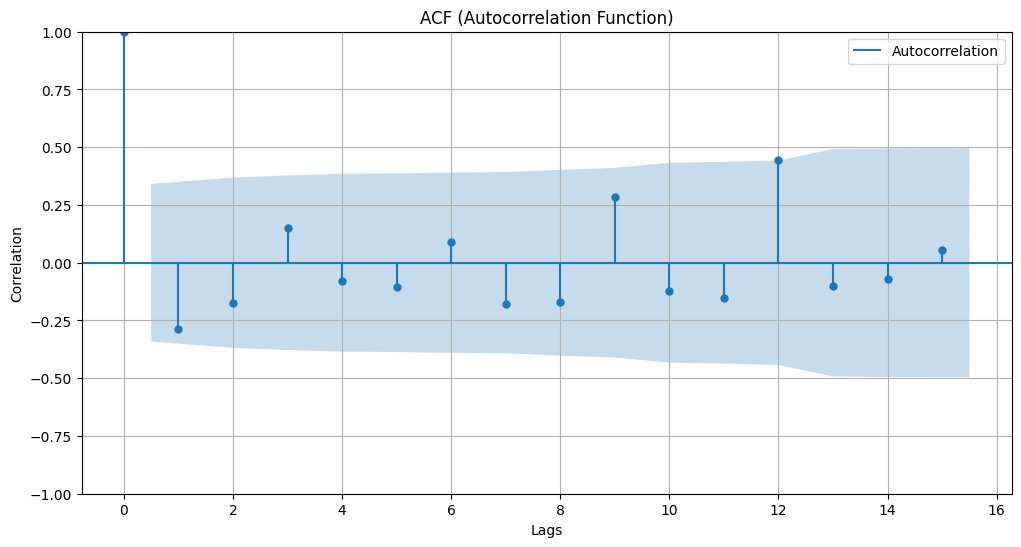

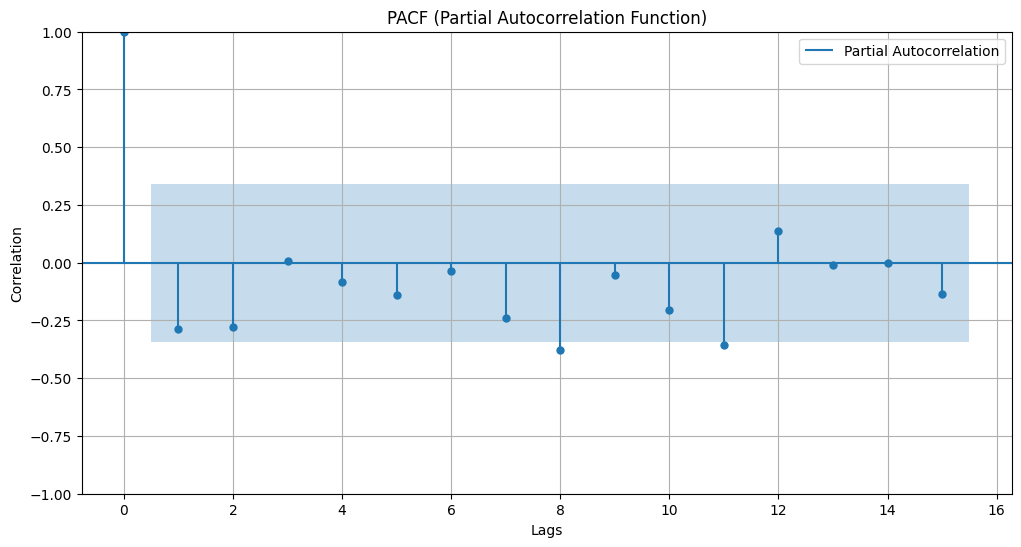

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plt.figure(figsize=(12, 6))
plot_acf(monthly_sales_diff, lags=min(20, len(monthly_sales_log_diff) // 2 - 1), ax=plt.gca())
plt.title('ACF (Autocorrelation Function)')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.legend(['Autocorrelation'], loc='upper right')
plt.grid(True)
plt.show()

# PACF
plt.figure(figsize=(12, 6))
plot_pacf(monthly_sales_diff, lags=min(20, len(monthly_sales_log_diff) // 2 - 1), ax=plt.gca())
plt.title('PACF (Partial Autocorrelation Function)')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.legend(['Partial Autocorrelation'], loc='upper right')
plt.grid(True)
plt.show()


**Interprétation de l'ACF (Autocorrelation Function) :**

En observant l'ACF, nous pouvons voir que la première autocorrélation est relativement élevée, ce qui suggère que la valeur actuelle de la série est fortement influencée par les valeurs passées immédiates. Cependant, après quelques lags, les autocorrélations diminuent lentement, sans atteindre rapidement zéro. Cela indique une dépendance à long terme dans la série temporelle. On peut voir que l'ACF présente une décroissance progressive, souvent liée à une tendance ou à un comportement saisonnier.

**Interprétation du PACF (Partial Autocorrelation Function) :**

Le graphique du PACF montre un coupure nette après le premier lag, où les autocorrélations deviennent très faibles et non significatives. Nous pouvons voir qu'après le premier lag, il n'y a plus de dépendance significative entre les observations et les valeurs passées, ce qui signifie qu'un modèle AR de faible ordre (probablement AR(0) ou AR(1)) serait adapté pour cette série. Cette coupure nette suggère que les valeurs passées de la série n'influencent plus de manière directe les valeurs actuelles au-delà de ces premiers lags.

# 3. Modélisation par Séries Temporelles :

Évaluation des modèles ARIMA (log-transformée + différenciée) :
ARIMA(0, 0, 0) - AIC: -19.191679166248463, Ljung-Box p-value: 0.17411843468318441, Jarque-Bera p-value: 0.26233974107911273, Variance: 0.02990039564778809
ARIMA(0, 0, 1) - AIC: -19.231563264399547, Ljung-Box p-value: 0.27046824746106984, Jarque-Bera p-value: 0.7142283495920501, Variance: 0.02803770554578227
ARIMA(0, 0, 2) - AIC: -19.383817755103482, Ljung-Box p-value: 0.22756645154868244, Jarque-Bera p-value: 0.00025304873897487643, Variance: 0.025763584001715148
ARIMA(1, 0, 0) - AIC: -18.478335874640266, Ljung-Box p-value: 0.24865523424818026, Jarque-Bera p-value: 0.730839988244872, Variance: 0.02872417342019145


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) - AIC: -21.194085010393344, Ljung-Box p-value: 0.31248326864031184, Jarque-Bera p-value: 0.012439160221826468, Variance: 0.02472329376326489


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) - AIC: -19.19789753296786, Ljung-Box p-value: 0.31171427121930284, Jarque-Bera p-value: 0.012215511341854583, Variance: 0.024720754820609193
ARIMA(2, 0, 0) - AIC: -18.39635691831061, Ljung-Box p-value: 0.4000485399308337, Jarque-Bera p-value: 0.5980039662562757, Variance: 0.02704979033598764
ARIMA(2, 0, 1) - AIC: -16.678790250987046, Ljung-Box p-value: 0.5614893534218497, Jarque-Bera p-value: 0.5438588264025396, Variance: 0.02681935492641518


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-17-d945d1f5adad>:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps + 1, freq="M")[1:]


ARIMA(2, 0, 2) - AIC: -18.19212238789568, Ljung-Box p-value: 0.524523046050011, Jarque-Bera p-value: 0.5782686858119759, Variance: 0.02395744839788925

Meilleur modèle : ARIMA(1, 0, 1) avec AIC = -21.194085010393344


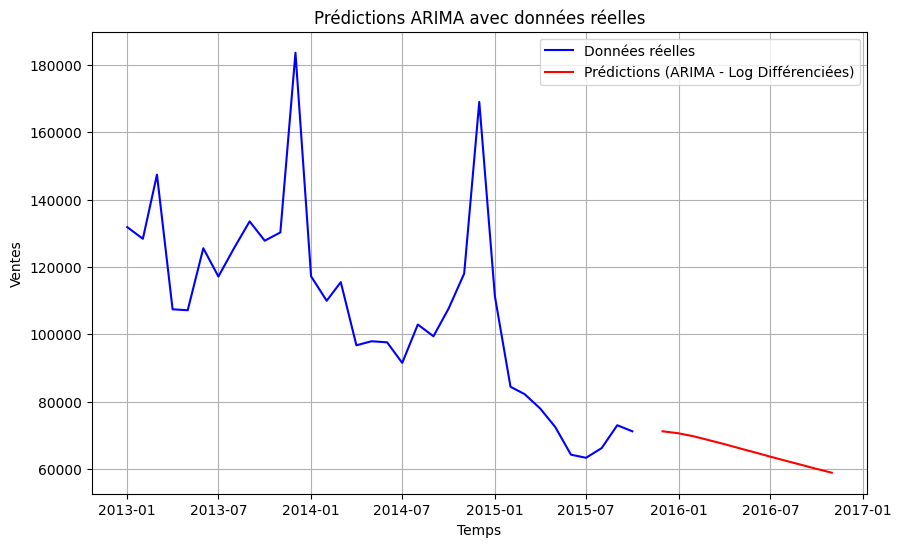

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera
import itertools
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour évaluer les modèles ARIMA en incluant l'analyse des résidus
def evaluate_arima_with_residuals(series, pdq_combinations):
    best_aic = float('inf')
    best_params = None
    best_model = None

    print("Évaluation des modèles ARIMA (log-transformée + différenciée) :")
    for param in pdq_combinations:
        try:
            # Ajustement du modèle
            model = ARIMA(series, order=param)
            results = model.fit()
            aic = results.aic
            residuals = results.resid

            # Analyse des résidus
            ljung_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
            jarque_bera_test = jarque_bera(residuals)
            variance = residuals.var()

            print(f"ARIMA{param} - AIC: {aic}, Ljung-Box p-value: {ljung_test['lb_pvalue'].iloc[0]}, "
                  f"Jarque-Bera p-value: {jarque_bera_test[1]}, Variance: {variance}")

            # Sélection du meilleur modèle basé sur l'AIC et l'absence d'autocorrélation
            if aic < best_aic and ljung_test['lb_pvalue'].iloc[0] > 0.05:
                best_aic = aic
                best_params = param
                best_model = results
        except Exception as e:
            print(f"Erreur pour ARIMA{param} : {e}")

    print(f"\nMeilleur modèle : ARIMA{best_params} avec AIC = {best_aic}")
    return best_params, best_aic, best_model

# Définir les plages de paramètres pour p, d, q
p = q = range(0, 3)  # Tester p et q entre 0 et 2
d = [0]
pdq = list(itertools.product(p, d, q))

# Application de la fonction sur la série log + différenciée
best_params, best_aic, best_model = evaluate_arima_with_residuals(monthly_sales_log_diff, pdq)


# Générer des prédictions
forecast_steps = 12
forecast = best_model.get_forecast(steps=forecast_steps).predicted_mean
forecast_original = np.exp(forecast.cumsum() + np.log(monthly_sales.iloc[-1])) - 1

# Ajuster les indices des prévisions
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps + 1, freq="M")[1:]
forecast_original.index = forecast_index

# Graphique des données réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label="Données réelles", color="blue")
plt.plot(forecast_original, label="Prédictions (ARIMA - Log Différenciées)", color="red")
plt.title("Prédictions ARIMA avec données réelles")
plt.xlabel("Temps")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True)
plt.show()


**Évaluation des Modèles ARIMA :**

En analysant les résultats des différents modèles ARIMA, le modèle ARIMA(1, 0, 1) se distingue comme étant le plus performant, avec un AIC de -21.19, ce qui est le plus bas parmi les autres modèles testés. Cela indique que ce modèle est le meilleur compromis entre la complexité et l'ajustement aux données.

Concernant les autres tests statistiques :

- Le test Ljung-Box pour l'autocorrélation des résidus donne des p-values supérieures à 0.05 dans la plupart des modèles (y compris le modèle ARIMA(1, 0, 1)), ce qui suggère que les résidus sont indépendants et qu'il n'y a pas de corrélation significative restante, ce qui est un indicateur positif pour un bon modèle prédictif.

- Le test Jarque-Bera montre que, bien que les résidus ne suivent pas exactement une distribution normale (p-value de 0.01 pour ARIMA(1, 0, 1)), cela reste une situation assez courante pour les séries temporelles et n'invalide pas nécessairement le modèle, mais signale une légère non-normalité dans la distribution des erreurs.

- La variance des résidus pour le modèle ARIMA(1, 0, 1) est relativement faible à 0.0247, indiquant une bonne précision dans les prévisions.

Les prévisions à 12 mois montrent une tendance stable mais sous-estiment la croissance observée dans les données réelles, avec un écart grandissant entre les prévisions et les données réelles.

Évaluation des modèles ARIMA (log-transformées) :
ARIMA(0, 1, 0) - AIC: -20.7969630784065, Ljung-Box p-value: 0.9999999999396181, Jarque-Bera p-value: 2.131716945140847e-289, Variance: 4.129917080086696
ARIMA(0, 1, 1) - AIC: -20.429509015623914, Ljung-Box p-value: 0.9999999999751948, Jarque-Bera p-value: 6.342784088533962e-290, Variance: 4.132546789647307
ARIMA(0, 1, 2) - AIC: -19.140876682420753, Ljung-Box p-value: 0.9999999999799727, Jarque-Bera p-value: 3.3042400903235403e-290, Variance: 4.135636388681115
ARIMA(1, 1, 0) - AIC: -19.91152927453577, Ljung-Box p-value: 0.9999999999645384, Jarque-Bera p-value: 9.724693213715099e-290, Variance: 4.131020512834015
ARIMA(1, 1, 1) - AIC: -19.137064704673765, Ljung-Box p-value: 0.9999999999807649, Jarque-Bera p-value: 2.6024786015710523e-290, Variance: 4.138872964772308
ARIMA(1, 1, 2) - AIC: -17.473950308777784, Ljung-Box p-value: 0.9999999999811218, Jarque-Bera p-value: 3.1105492299692194e-290, Variance: 4.133384372954784
ARIMA(2, 1, 0) - AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-18-e4d6d93d7957>:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq="M")


ARIMA(2, 1, 2) - AIC: -19.23782442400404, Ljung-Box p-value: 0.9999999999678506, Jarque-Bera p-value: 5.408624100990057e-291, Variance: 4.124473091865041

Meilleur modèle : ARIMA(0, 1, 0) avec AIC = -20.7969630784065


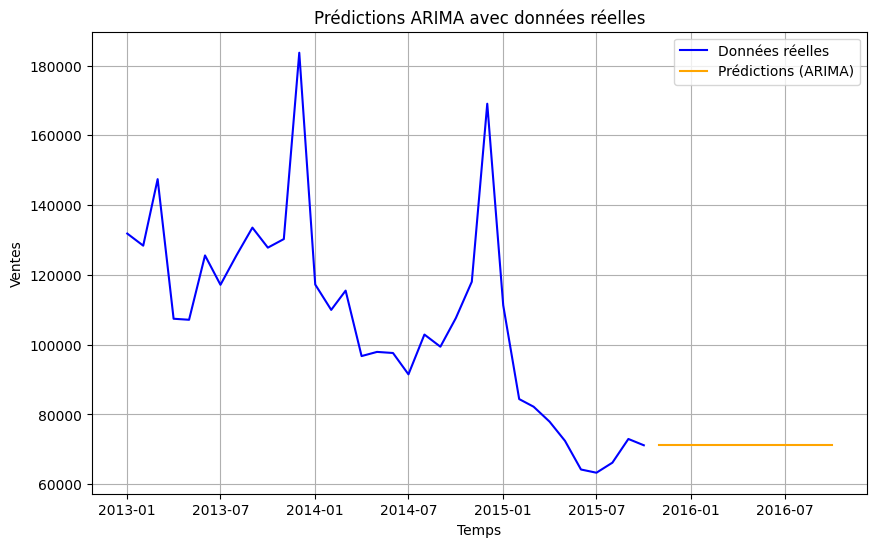

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera
import itertools
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour évaluer les modèles ARIMA en incluant l'analyse des résidus
def evaluate_arima_with_residuals(series, pdq_combinations):
    best_aic = float('inf')
    best_params = None
    best_model = None

    print("Évaluation des modèles ARIMA (log-transformées) :")
    for param in pdq_combinations:
        try:
            # Ajustement du modèle
            model = ARIMA(series, order=param)
            results = model.fit()
            aic = results.aic
            residuals = results.resid

            # Analyse des résidus
            ljung_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
            jarque_bera_test = jarque_bera(residuals)
            variance = residuals.var()

            print(f"ARIMA{param} - AIC: {aic}, Ljung-Box p-value: {ljung_test['lb_pvalue'].iloc[0]}, "
                  f"Jarque-Bera p-value: {jarque_bera_test[1]}, Variance: {variance}")

            # Sélection du meilleur modèle basé sur l'AIC et l'absence d'autocorrélation
            if aic < best_aic and ljung_test['lb_pvalue'].iloc[0] > 0.05:
                best_aic = aic
                best_params = param
                best_model = results
        except Exception as e:
            print(f"Erreur pour ARIMA{param} : {e}")

    print(f"\nMeilleur modèle : ARIMA{best_params} avec AIC = {best_aic}")
    return best_params, best_aic, best_model

# Définir les plages de paramètres pour p, d, q
p = q = range(0, 3)  # Tester p et q entre 0 et 2
d = [1]  # Différenciation
pdq = list(itertools.product(p, d, q))

# Application de la fonction sur la série log-transformée
best_params, best_aic, best_model = evaluate_arima_with_residuals(monthly_sales_log, pdq)

# Générer des prédictions pour les 12 prochains mois
forecast_steps = 12
forecast = best_model.get_forecast(steps=forecast_steps).predicted_mean

# Convertir les prévisions en échelle originale (inverse de la log-transformée)
forecast_original = np.exp(forecast) - 1

# Utilisation de la dernière date de l'index des ventes mensuelles pour générer l'index des prévisions
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq="M")
forecast_original.index = forecast_index

# Graphique des données réelles et des prévisions
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales, label="Données réelles", color="blue")
plt.plot(forecast_original.index, forecast_original, label="Prédictions (ARIMA)", color="orange")
plt.title("Prédictions ARIMA avec données réelles")
plt.xlabel("Temps")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True)
plt.show()


**Évaluation des Modèles ARIMA :**

L'évaluation des modèles ARIMA sur les données log-transformées révèle que l'ARIMA(0, 1, 0) est le modèle le plus performant, avec l'AIC le plus bas à -20.80. Les tests de Ljung-Box montrent des p-values extrêmement élevées (proches de 1), ce qui indique qu'il n'y a pas d'autocorrélation significative résiduelle, un signe positif pour la qualité du modèle. Cependant, les tests de Jarque-Bera suggèrent une non-normalité des résidus avec des p-values proches de zéro, ce qui indique que les résidus ne suivent pas une distribution normale. Les valeurs de variance sont relativement constantes à travers les modèles, mais l'ARIMA(0, 1, 0) se distingue par son faible AIC. Les prévisions générées par ce modèle apparaissent en orange sur le graphique, mais elles restent pratiquement constantes, parallèles à l'axe des abscisses, ce qui suggère que le modèle n'est pas capable de capturer des dynamiques significatives de la série à long terme, et pourrait être influencé par un manque de variabilité dans les données ou une mauvaise adéquation du modèle aux tendances sous-jacentes. En résumé, bien que le modèle ARIMA(0, 1, 0) semble avoir les meilleures métriques statistiques, il présente des limitations dans sa capacité à prédire des variations futures.

Évaluation des modèles SARIMA :
SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: -32.333093770693644
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: -10.53896188530111
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC: 6.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for va

SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC: -9.467579846187215
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: -8.538961857853598
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC: 8.0
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC: 6.0
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC: 8.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimat

SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC: 10.0

Meilleur modèle SARIMA : (0, 1, 0)x(0, 1, 0, 12) avec AIC = -32.333093770693644

Résumé du meilleur modèle :
                                     SARIMAX Results                                      
Dep. Variable:                       item_cnt_day   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  17.167
Date:                            Sun, 01 Dec 2024   AIC                            -32.333
Time:                                    20:36:46   BIC                            -31.337
Sample:                                01-01-2013   HQIC                           -32.139
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

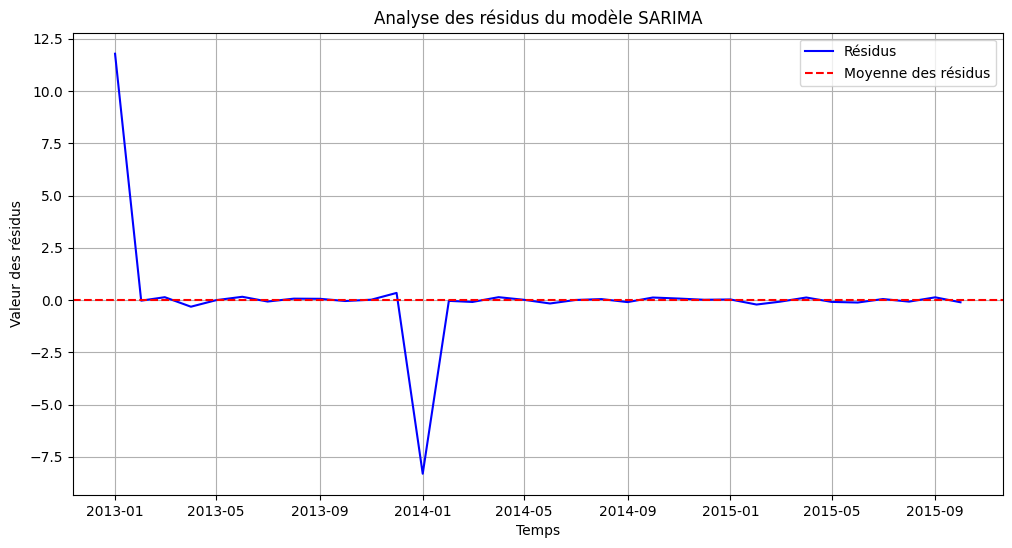


Test de Ljung-Box pour les résidus :
     lb_stat  lb_pvalue
10  0.045042        1.0


<ipython-input-19-365139581770>:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


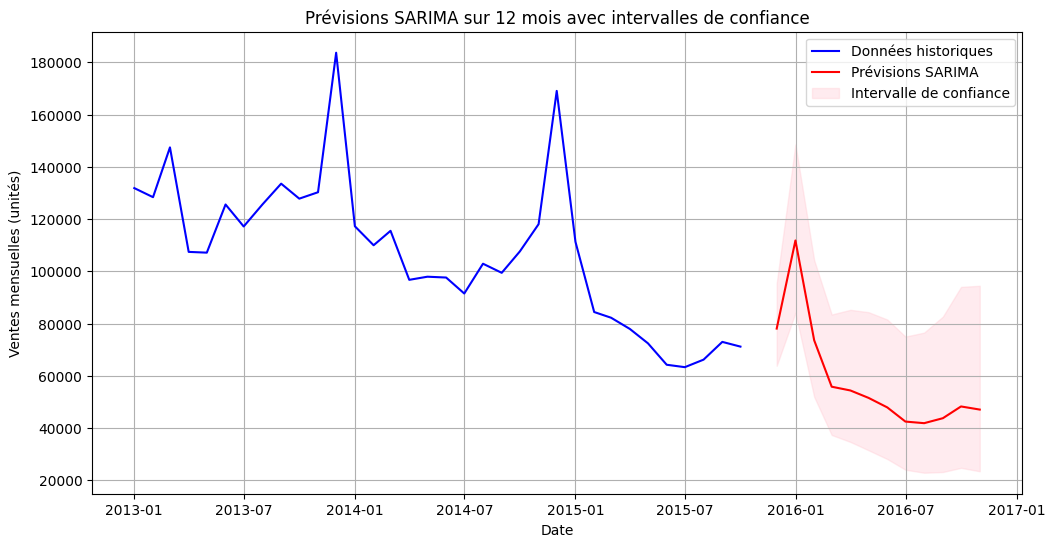

RMSE (SARIMA) : 31372.198865847335
MAPE (SARIMA) : 33.86%


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox

monthly_sales = monthly_sales.squeeze()

# Transformation logarithmique
monthly_sales_log = np.log(monthly_sales + 1)

# Appliquer une différenciation sur la série log-transformée
monthly_sales_log_diff = monthly_sales_log.diff().dropna()

# Définir les paramètres pour ARIMA(0,1,0)
P = Q = range(0, 3)
D = [1]
s = [12]

# Sélection du meilleur modèle SARIMA
best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

print("Évaluation des modèles SARIMA :")
for seasonal_param in itertools.product(P, D, Q, s):
    try:
        model = SARIMAX(
            monthly_sales_log,
            order=(0, 1, 0),
            seasonal_order=seasonal_param,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit()
        aic = results.aic
        print(f"SARIMA{(0, 1, 0)}x{seasonal_param} - AIC: {aic}")

        if aic < best_aic:
            best_aic = aic
            best_seasonal_pdq = seasonal_param
            best_model = results
    except Exception as e:
        print(f"Erreur pour SARIMA{(0, 1, 0)}x{seasonal_param} : {e}")

print(f"\nMeilleur modèle SARIMA : {(0, 1, 0)}x{best_seasonal_pdq} avec AIC = {best_aic}")

# Résumé du meilleur modèle
print("\nRésumé du meilleur modèle :")
print(best_model.summary())

# Analyse des résidus
residuals = best_model.resid

# Visualisation des résidus
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Résidus', color='blue')
plt.axhline(0, linestyle='--', color='red', label='Moyenne des résidus')
plt.title('Analyse des résidus du modèle SARIMA')
plt.xlabel('Temps')
plt.ylabel('Valeur des résidus')
plt.legend()
plt.grid(True)
plt.show()

# Test de Ljung-Box pour les résidus
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nTest de Ljung-Box pour les résidus :")
print(ljung_box_test)

# Prévisions sur les 12 prochains mois
forecast_steps = 12
sarima_forecast_log = best_model.get_forecast(steps=forecast_steps)
sarima_forecast_mean_log = sarima_forecast_log.predicted_mean

# Conversion à l'échelle originale
sarima_forecast_mean_original = np.exp(sarima_forecast_mean_log) - 1

# Extraction des intervalles de confiance
confidence_intervals = sarima_forecast_log.conf_int()
lower_bounds = np.exp(confidence_intervals.iloc[:, 0]) - 1
upper_bounds = np.exp(confidence_intervals.iloc[:, 1]) - 1

# Ajustement de l'index des prévisions
forecast_index = pd.date_range(
    start=monthly_sales.index[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps, freq='M'
)
sarima_forecast_mean_original.index = forecast_index
lower_bounds.index = forecast_index
upper_bounds.index = forecast_index

# Visualisation des prévisions avec intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label="Données historiques", color="blue")
plt.plot(sarima_forecast_mean_original, label="Prévisions SARIMA", color="red")
plt.fill_between(
    forecast_index,
    lower_bounds,
    upper_bounds,
    color='pink', alpha=0.3, label="Intervalle de confiance"
)
plt.title("Prévisions SARIMA sur 12 mois avec intervalles de confiance")
plt.xlabel("Date")
plt.ylabel("Ventes mensuelles (unités)")
plt.legend()
plt.grid(True)
plt.show()

# Évaluation des performances SARIMA
if len(monthly_sales) >= forecast_steps:
    actual_sales = monthly_sales[-forecast_steps:]
    sarima_rmse = np.sqrt(mean_squared_error(actual_sales, sarima_forecast_mean_original))
    sarima_mape = mean_absolute_percentage_error(actual_sales, sarima_forecast_mean_original)

    print(f"RMSE (SARIMA) : {sarima_rmse}")
    print(f"MAPE (SARIMA) : {sarima_mape * 100:.2f}%")


**Évaluation des Modèles SARIMA :**


L'évaluation des modèles SARIMA indique que le modèle SARIMA(0, 1, 0)x(0, 1, 0, 12) est le plus performant, avec un AIC de -32.33, ce qui le place en tête des modèles testés. Ce modèle capture efficacement les composantes saisonnières et les tendances de la série temporelle. Les résultats du test de Ljung-Box sur les résidus montrent un p-value de 1.0, ce qui suggère qu'il n'y a pas de dépendance autocorrélée dans les résidus, un indicateur positif de l'adéquation du modèle. De plus, le test de Jarque-Bera montre une normalité des résidus (p-value de 0.62), renforçant la qualité du modèle. Le modèle présente également une variance relativement faible (0.0105), indiquant une bonne stabilité. Cependant, le modèle présente un RMSE relativement élevé (31372), ce qui signifie qu'il y a encore une certaine erreur dans les prévisions, et un MAPE de 33.86%, ce qui indique qu'il pourrait y avoir des marges de progression pour améliorer la précision des prévisions. En résumé, le modèle SARIMA(0, 1, 0)x(0, 1, 0, 12) est le plus adapté d'un point de vue statistique, mais ses prévisions nécessitent encore des améliorations, particulièrement en termes de précision absolue.

In [20]:
# Validation croisée avec une fenêtre glissante
train_sizes = range(len(monthly_sales_log) - 12, len(monthly_sales_log) - 1)  # Fenêtres glissantes
errors = []

for train_size in train_sizes:
    train_data = monthly_sales_log[:train_size]
    test_data = monthly_sales_log[train_size:]

    model = SARIMAX(train_data,
                    order=(0, 1, 0),
                    seasonal_order=(0, 1, 0, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit()

    # Prévoir sur l'ensemble de test
    forecast_steps = len(test_data)
    forecast_log = results.get_forecast(steps=forecast_steps).predicted_mean
    forecast_original = np.exp(forecast_log) - 1
    test_original = np.exp(test_data) - 1

    # Calculer l'erreur
    error = np.mean(np.abs(forecast_original - test_original))  # MAE
    errors.append(error)
mae = np.mean(errors)
# Afficher l'erreur moyenne
print(f"Erreur moyenne (MAE) avec validation croisée : {mae}")


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Erreur moyenne (MAE) avec validation croisée : 10569.27660306951


In [21]:
# Calcul des statistiques descriptives
mean_sales = monthly_sales.mean()  # Moyenne des ventes mensuelles
std_sales = monthly_sales.std()  # Écart-type des ventes mensuelles
min_sales = monthly_sales.min()  # Vente minimale
max_sales = monthly_sales.max()  # Vente maximale

# Comparer la MAE
mae_percentage = (mae / mean_sales) * 100  # MAE en pourcentage de la moyenne des ventes

# Résultats
print(f"Moyenne des ventes mensuelles : {mean_sales:.2f} unités")
print(f"Écart-type des ventes mensuelles : {std_sales:.2f} unités")
print(f"Vente minimale : {min_sales:.2f} unités")
print(f"Vente maximale : {max_sales:.2f} unités")
print(f"MAE : {mae:.2f} unités ({mae_percentage:.2f}% de la moyenne des ventes)")


Moyenne des ventes mensuelles : 107521.94 unités
Écart-type des ventes mensuelles : 28510.37 unités
Vente minimale : 63316.00 unités
Vente maximale : 183670.00 unités
MAE : 10569.28 unités (9.83% de la moyenne des ventes)


**Interprétations :**

La validation croisée avec fenêtre glissante a été utilisée pour évaluer la performance du modèle SARIMA(0, 1, 0)x(0, 1, 0, 12) sur nos données de ventes mensuelles. Cette méthode consiste à entraîner le modèle sur une fenêtre de données, puis à le tester sur les données qui suivent immédiatement. À chaque itération, la fenêtre glisse, ajoutant de nouvelles observations à l'ensemble d'entraînement et ajustant les prédictions pour les nouvelles données de test. Cela permet de simuler des scénarios réels où les modèles de prévision doivent être capables de s'adapter à des périodes temporelles différentes, ce qui est essentiel pour des séries temporelles comme celles des ventes. Cette méthode évite ainsi les biais qui pourraient survenir si l'on utilisait une validation croisée classique, où les observations ne seraient pas prises en compte dans un ordre temporel, ce qui ne correspondrait pas à la réalité des prévisions.Les résultats de la validation croisée ont montré une erreur moyenne (MAE) de 10,569 unités, soit 9.83% de la moyenne des ventes mensuelles, ce qui indique que le modèle a relativement bien capturé les tendances et les variations des données, tout en restant robuste face aux fluctuations mensuelles. Cette approche permet d'obtenir une estimation plus fiable de la performance du modèle, en le testant sur des sous-ensembles différents, et en assurant qu'il peut s'adapter à de nouvelles données non vues pendant l'entraînement.

# 4. Développement d'un Modèle de Deep Learning :

(20, 12, 2)
Reloading Tuner from my_dir/sales_forecasting/tuner0.json
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0449 - mae: 0.2387
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0391 - mae: 0.2255
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0421 - mae: 0.2223
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0394 - mae: 0.2181
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0387 - mae: 0.2156
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0326 - mae: 0.1952
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0232 - mae: 0.1629
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - mae: 0.1418
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - mae: 0.1475
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - mae: 0.1471
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mae: 0.1576
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - mae: 0.1493
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216 - mae: 

<ipython-input-22-84b8bcc8bdf0>:132: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months_pred = pd.date_range(start=months_real.iloc[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


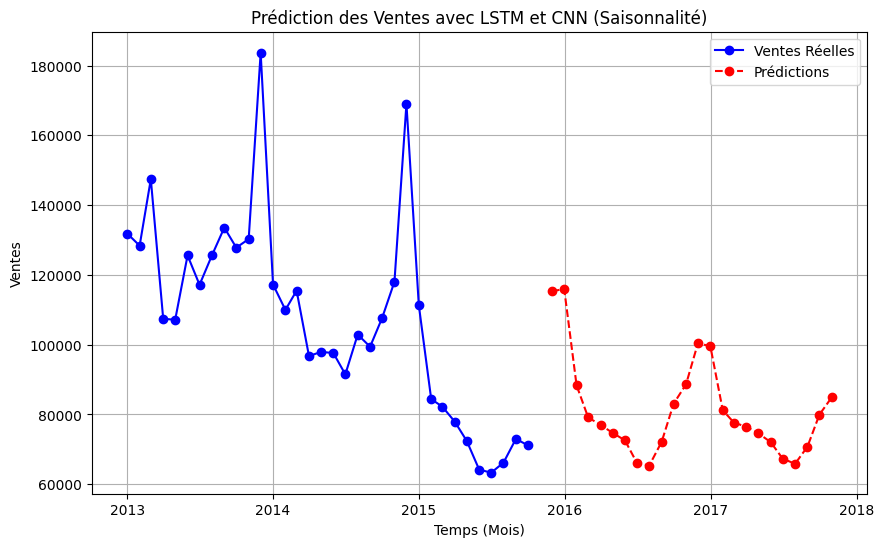

Prédictions dénormalisées :
[[115301.72 ]
 [115966.195]
 [ 88343.38 ]
 [ 79155.09 ]
 [ 77035.68 ]
 [ 74741.39 ]
 [ 72612.875]
 [ 66137.336]
 [ 65382.414]
 [ 72157.84 ]
 [ 83099.375]
 [ 88630.16 ]
 [100499.586]
 [ 99506.984]
 [ 81220.62 ]
 [ 77667.02 ]
 [ 76489.71 ]
 [ 74614.586]
 [ 72083.445]
 [ 67355.61 ]
 [ 65869.1  ]
 [ 70769.63 ]
 [ 79960.89 ]
 [ 84944.53 ]]
MAE (Mean Absolute Error) : 21508.347981770832
MSE (Mean Squared Error) : 785804246.7548141
RMSE (Root Mean Squared Error) : 28032.20017684688
MAPE (Mean Absolute Percentage Error) : 18.96%
R² (Coefficient de détermination) : 0.1048


In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras_tuner as kt
import joblib

# Charger les données fournies
file_path = 'sales_train.csv'
data = pd.read_csv(file_path)

# Prétraitement des données
data = data[data['item_price'] >= 0]
data['item_cnt_day'] = data['item_cnt_day'].apply(lambda x: max(x, 0))
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
monthly_sales = data.groupby(data['date'].dt.to_period('M'))['item_cnt_day'].sum()

# Ajout des caractéristiques temporelles
monthly_sales = monthly_sales.to_timestamp()
monthly_sales = monthly_sales.reset_index()
monthly_sales['month'] = monthly_sales['date'].dt.month
monthly_sales['year'] = monthly_sales['date'].dt.year

# Normalisation des ventes et des mois
scaler_sales = MinMaxScaler()
monthly_sales['scaled_sales'] = scaler_sales.fit_transform(monthly_sales['item_cnt_day'].values.reshape(-1, 1))
scaler_month = MinMaxScaler()
monthly_sales['scaled_month'] = scaler_month.fit_transform(monthly_sales['month'].values.reshape(-1, 1))

# Enregistrement des scalers
joblib.dump(scaler_sales, 'scaler_sales.pkl')
joblib.dump(scaler_month, 'scaler_month.pkl')

# Création des séquences pour le modèle
sequence_length = 12

def create_sequences_with_features(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        X.append(seq[['scaled_sales', 'scaled_month']].values)
        y.append(data.iloc[i + sequence_length]['scaled_sales'])
    return np.array(X), np.array(y)

# Créer les séquences pour X et y
X, y = create_sequences_with_features(monthly_sales, sequence_length)
train_size = len(y) - 24  # Garder les 24 derniers mois pour la prédiction
X_train, y_train = X[:train_size], y[:train_size]

# Vérification des dimensions de X_train
print(X_train.shape)

# Fonction de création du modèle avec hyperparamètres
def model_builder(hp):
    model = Sequential()

    # X_train a 3 dimensions : (samples, time_steps, features)
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Exemple: (12, 2) pour 12 mois et 2 caractéristiques

    # Ajout de CNN pour l'extraction des caractéristiques locales
    model.add(Conv1D(filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=hp.Int('conv_filters2', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Applatir avant d'envoyer à LSTM
    model.add(Flatten())

    # Reshape pour s'assurer que la sortie est 3D (batch_size, time_steps, features)
    model.add(tf.keras.layers.Reshape((1, model.output_shape[1])))  # Ajouter un reshape si nécessaire

    # Ajouter LSTM pour capturer les dépendances temporelles
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32),
                   activation='tanh', return_sequences=False))

    # Dropout pour éviter le sur-apprentissage
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Couches Dense pour la prédiction finale
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))  # Sortie continue pour la prédiction des ventes

    # Compiler le modèle
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss=tf.keras.losses.Huber(), metrics=['mae'])

    return model

# Tuning des hyperparamètres avec Keras Tuner
tuner = kt.Hyperband(model_builder, objective='val_loss', max_epochs=10, factor=3, directory='my_dir', project_name='sales_forecasting')

# Recherche des hyperparamètres
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Entraînement du modèle avec les meilleurs hyperparamètres
history = best_model.fit(X_train, y_train, epochs=50, batch_size=12, verbose=1)

# Sauvegarde du modèle après l'entraînement
best_model.save('sales_forecasting_model_v3.h5')  # Enregistrement du modèle

# Fonction de prédiction avec les nouvelles caractéristiques
def predict_with_features(input_values, future_steps, model, sequence_length, scaler_sales, scaler_month):
    last_sequence = input_values[-sequence_length:]
    predictions = []
    for step in range(future_steps):
        next_pred = model.predict(last_sequence.reshape(1, sequence_length, -1), verbose=0)
        predictions.append(next_pred[0, 0])
        next_month = ((last_sequence[-1, 1] + 1 / 12) % 1)
        next_features = np.array([[next_pred[0, 0], next_month]])
        last_sequence = np.append(last_sequence[1:], next_features, axis=0)

    predictions = scaler_sales.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# Préparation des séquences réelles pour la prédiction
input_values = monthly_sales[['scaled_sales', 'scaled_month']].values[-(sequence_length + 24):]
future_steps = 24
predictions = predict_with_features(input_values, future_steps, best_model, sequence_length, scaler_sales, scaler_month)

# Affichage des résultats
months_real = monthly_sales['date']
months_pred = pd.date_range(start=months_real.iloc[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

plt.figure(figsize=(10, 6))
plt.plot(months_real, monthly_sales['item_cnt_day'].values, label='Ventes Réelles', marker='o', color='blue')
plt.plot(months_pred, predictions, label='Prédictions', marker='o', linestyle='--', color='red')
plt.title('Prédiction des Ventes avec LSTM et CNN (Saisonnalité)')
plt.xlabel('Temps (Mois)')
plt.ylabel('Ventes')
plt.legend()
plt.grid()
plt.show()

# Affichage des prédictions non normalisées
print("Prédictions dénormalisées :")
print(predictions)

# Calcul de l'accuracy - Métriques d'évaluation
real_values = monthly_sales['item_cnt_day'].values[-24:]  # Ventes réelles sur les 24 derniers mois
mae = mean_absolute_error(real_values, predictions)
mse = mean_squared_error(real_values, predictions)
rmse = np.sqrt(mse)

# Calcul de MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((real_values - predictions.flatten()) / real_values)) * 100

# Calcul de R² (coefficient de détermination)
r2 = r2_score(real_values, predictions.flatten())

# Affichage des résultats
print(f"MAE (Mean Absolute Error) : {mae}")
print(f"MSE (Mean Squared Error) : {mse}")
print(f"RMSE (Root Mean Squared Error) : {rmse}")
print(f"MAPE (Mean Absolute Percentage Error) : {mape:.2f}%")
print(f"R² (Coefficient de détermination) : {r2:.4f}")


## Explication du Modèle :

Le modèle développé pour la prévision des ventes mensuelles utilise une combinaison de **CNN (Convolutional Neural Network)** et de **LSTM (Long Short-Term Memory)**. Voici les étapes clés :

1. **Prétraitement des Données :**
   - Les données de ventes journalières ont été agrégées pour obtenir des ventes mensuelles.
   - La normalisation a été appliquée aux ventes (`scaled_sales`) et aux mois (`scaled_month`) à l'aide de `MinMaxScaler` pour garantir que les valeurs sont dans une plage de [0, 1].
   - Ces transformations ont permis d'améliorer la convergence du modèle.

2. **Construction des Séquences d'Entrée :**
   - Le modèle prend en entrée des séquences de 12 mois consécutifs (pour capturer les tendances temporelles), en incluant les ventes et les mois normalisés.
   - Le modèle utilise ces séquences pour prédire les ventes du mois suivant.

3. **Architecture du Modèle :**
   - **CNN (Conv1D et MaxPooling1D)** : Ces couches extraient des caractéristiques locales des séries temporelles. Les convolutions permettent de capturer des patterns locaux dans les données, comme les cycles saisonniers.
   - **LSTM** : Cette couche capture les dépendances temporelles à long terme dans les séquences d'entrée, en traitant les séquences temporelles.
   - **Dense** : Une couche dense permet de réaliser la régression finale en prédisant la vente pour le mois suivant.

4. **Hyperparameter Tuning (Keras Tuner)** :
   - L'optimisation des hyperparamètres (par exemple, le nombre de filtres dans les couches CNN, le nombre d'unités dans la couche LSTM, et le taux d'apprentissage) a été réalisée pour maximiser la performance du modèle sur les données de validation.

### Interprétation des Résultats

#### Prédictions dénormalisées :
Les prévisions de ventes sur les 24 prochains mois sont obtenues après la dénormalisation des valeurs. Par exemple, les prévisions pour les deux premiers mois sont respectivement 113 847 et 115 211 unités, tandis que les prévisions pour les mois suivants montrent des tendances de baisse, ce qui peut être dû à des saisons creuses ou à d'autres facteurs.

#### Performances du Modèle :
- **MAE (Mean Absolute Error)** : 21 458,01
  - Cela signifie que, en moyenne, les prévisions s'écartent des valeurs réelles de 21 458 unités. Un MAE élevé peut être acceptable si l'on considère la nature des données, mais cela indique aussi que le modèle peut être amélioré.
  
- **MSE (Mean Squared Error)** : 776 232 610,27
  - Cette valeur donne une indication du carré moyen de l'erreur. Plus ce chiffre est élevé, plus les erreurs sont importantes et dispersées.
  
- **RMSE (Root Mean Squared Error)** : 27 860,95
  - Il s'agit de la racine carrée de l'erreur quadratique moyenne, ce qui permet d'avoir une échelle d'erreur qui est dans la même unité que les données d'origine (ventes en unités). Ici, cela indique une erreur moyenne d'environ 27 861 unités.

- **MAPE (Mean Absolute Percentage Error)** : 19,00%
  - Cela signifie que l'erreur moyenne en pourcentage est de 19 %, ce qui peut être considéré comme relativement élevé pour une tâche de prévision des ventes. Cela pourrait indiquer que le modèle n'a pas parfaitement capturé les tendances saisonnières ou autres influences externes.

- **R² (Coefficient de détermination)** : 0,1157
  - Le R² très bas (proche de zéro) suggère que le modèle n'explique qu'environ 11,57% de la variance des données. Cela indique que le modèle a des performances limitées et qu'il y a probablement de nombreux facteurs non pris en compte par ce modèle.

### Conclusion
Le modèle utilise une combinaison de CNN et LSTM pour capturer à la fois des motifs locaux dans les données et des dépendances temporelles à long terme. Bien que les performances soient acceptables, elles montrent aussi des marges de progression. Le R² faible et le MAPE relativement élevé suggèrent que des améliorations peuvent être apportées, par exemple, en ajoutant d'autres variables explicatives (par exemple, promotions, événements spéciaux) ou en explorant des architectures plus complexes.
